# Stylometry
In this jupyter notebook I will cover the basics of performing stylometric analysis on a large collection of texts.
## Using this notebook
The code in this notebook is distributed across a few different code blocks. You will need to run them top to bottom, but the actual analysis does not happen until the last block. To run everything, simply click on "Run All" in the "Cell" menu. I have also provided a plain python file that you can run from the commmand line.

## Importing necessary libraries
This code block imports the libraries I will use.

In [16]:
import re, os, sys, platform, json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

# Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib.colors

## Adjustable parameters: Analysis
The parameters that you might want to adjust for your analysis are contained in the following code block.


**ngrams** is an integer that will determine the size of n-gram you use for analysis. 1 will look at single words, 2 will look at two at a time, 3 will look at three at a time, etc. 1 grams work best for most analyses. More than 3 will be slow and often result in very sparse data that is hard to interpret.

**commonWords** is an integer that determines how frequent a character must be in the corpus to be considered in the stylometric analysis. 500 will use the 500 most common words across all texts. You can set this to None if you do not want to limit words in this way

**limitVocab** is a boolean (True or False). Set to True if you want to specify a specific vocabulary

**limitVocabularyFile** is the name of a file that contains the vocabulary you are interested in. The file should have one token per line. This line is only read if limitVocab is set to True.

In [17]:
# Size of n-grams:
ngrams = 1

# Limit the number of words to look at
commonWords = 500 

# Set the vocabulary you are interested in
limitVocab = False

# Vocabulary file
limitVocabularyFile = "vocab.txt"

## Adjustable parameters: Appearance
These parameters will help you set the appearance of the plot itself.

**labelTypes** is a tuple that specifies the nature of the corpus labeling. Here, the sample corpus files are all  named with the convention author_title_section_genre.txt. Each type of label is one element in this tuple, in the same order they appear in the name

**colorValue** this integer specifies which label should be used to generate a color scheme for the plot. 2 points to the 3rd element in the tuple, the siku categorization. There are three different siku categories reflected in the dataset, making this a good option. Here you should pick whichever label your analysis is focused on. More than 8 or so elements, however, will generate colors that are hard to tell apart.

**labelValue** this integer specifies which label should be used for labeling the points in the plot. 0 points to the 1st element in the tuple, the title.

**pointSize** is an integer that sets how large the points in the plot tare

**pointLabels** is a boolean (True or False) that specifies if the points should be labeled.

**plotLoadings** is a boolean that specifies if the vocabulary should be drawn on the plot (which will aid in interpretation). The further a term is from the center of the plot, the more it is influencing texts in a given direction.

**hidePoints** is a boolean that specifies of the points should be drawn. Set to False to see the loadings better.

**outputDimensions** is a tuple that sets the width and height of the output plot in inches. The inner values can be either integers or floats.

**outputFile** contains the name of the outputfile, where the plot will be saved. The file extension will determine file type. png, pdf, jpg, tif, and others are all valid selections. On Macs, because of an oddity of the plotting library, pdfs will be very large. You can fix this by opening the file with adobe illustrator (or another similar program) and then saving a copy. This is because the entire font is embedded in the file.

In [18]:
# Types of labels for documents in the corpus
labelTypes = ('author', 'title', 'section', 'genre') # tuple with strings

# Index of label used to set Color:
colorValue = 1 # Index of label to use for color (integer). Here 1 points to "_h/c/t/x"

# Index of label to use for plot labels (if points are labeled)
labelValue = 0 # Index of label to use for labels (integer). Here 0 points to "title"

# Point size (integer)
pointSize = 5 #8

# Show point labels (add labels for each text):
pointLabels = False # True or False

# Plot loadings (write the characters to the plot)
plotLoadings = True # True or False

# Hide points (useful for seeing loadings better):
hidePoints = True # True or False

# Output file info (dimensions are in inches (width, height)):
outputDimensions = (10, 7.5) # Tuple of integers or floats

# Output file extension determines output type. Save as a pdf if you want to edit in illustator
# PDF Output on mac is very large, but just opening and saving a copy in illustrator will fix this
outputFile = "WS_PCA.pdf" #"myfigure.png"

## Adjustable Parameters: no need to change
This parameters can be adjusted, but you may as well leave them as they are.

**pcaComponents** is an integer that sets how many principal components should be calculated. We are only using two in this analysis, but as you work more with these plots, you can consider setting this higher (but you will also have to adjust later parts of the script to make them do anything). The maximum this can be is the number of variables (here the 500 words) minus one (so 499 in this case).

**corpusFolder** is the name of the folder that holds the corpus files. Just leave this as "corpus" if you put your files in a folder called "corpus".

**removeItemsFile** is a string that points to words (tokens) that you want to remove from consideration. Each token to be removed should be on a line in the specified file.

In [19]:
# How many components?
pcaComponents = 2         # Only useful for digging even deeper in the data

# Input folder
corpusFolder = "../corpus"

# Items to remove from consideration:
removeItemsFile = "../remove.txt"

# Nothing beyond here needs editing!!
The comments in the code itself explain what is happening. If you run the script from a terminal, it will open a new window with your plot. It will look like the code keeps running until you close this window. This is an interactive explorer you can use to study the plot itself. Here it will just insert the figure after the codeblock.

Loading, cleaning, and tokenizing
42 of 42 processed
Vectorizing
Normalizing values
Performing PCA
Setting plot info
Plotting texts
Rendering Loadings


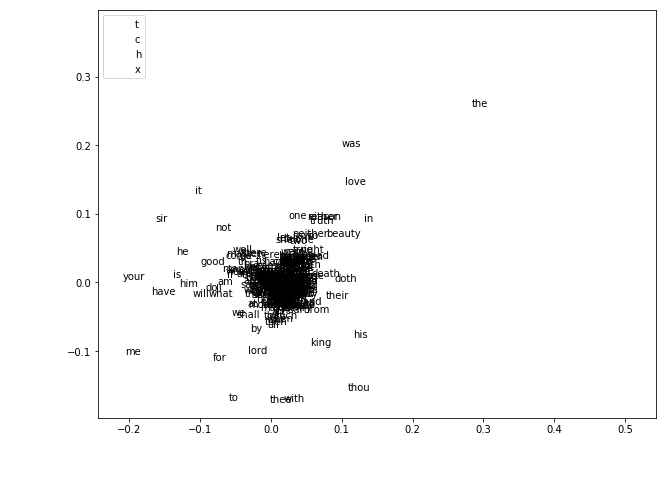

In [20]:
####################
# Type Enforcement #
####################

# This section enforces the input values for all the adjustable variables. This
# is to make sure the script isn't run incorrectly.

# function to check values
def valueChecker(varname, typeofobj, value):
    if type(typeofobj) == type:
        if typeofobj == bool and type(value) != typeofobj:
            print(f"{varname} must be a {typeofobj} (True or False). Please fix to run script.")
            sys.exit()
        if type(value) != typeofobj:
            print(f"{varname} must be {typeofobj}. Please fix to run script.")
            sys.exec_info()
            sys.exit() 
    elif type(typeofobj) == tuple:
        if type(value) != typeofobj[0] and type(value) != typeofobj[1]:
            print(f"{varname} must be {typeofobj[0]} or {typeofobj[1]}. Please fix to run script.")
            sys.exit() 

# check values
valueChecker('ngrams', int, ngrams)
valueChecker('commonWords', (int, None), commonWords)
valueChecker('limitVocab', bool, limitVocab)
valueChecker('colorValue', int, colorValue)
valueChecker('labelValue', int, labelValue)
valueChecker('pointSize', int, pointSize)
valueChecker('pointLabels', bool, pointLabels)
valueChecker('plotLoadings', bool, plotLoadings)
valueChecker('hidePoints', bool, hidePoints)
valueChecker('outputFile', str, outputFile)
valueChecker('pcaComponents', int, pcaComponents)
valueChecker('corpusFolder', str, corpusFolder)
valueChecker('removeItemsFile', str, removeItemsFile)

# check tuples and internal values
if type(labelTypes) != tuple:
    print('labelTypes must be a tuple. Please fix to run script.')
    sys.exit()
else:
    for lab in labelTypes:
        valueChecker('labelType item', str, lab)

if type(outputDimensions) != tuple:
    print(f"outputDimensions must be {tuple}. Please fix to run the script")
else:
    for d in outputDimensions:
        valueChecker("outerDimension value", (float, int), d)

# Load in external files
try:
    removeItems = []
    with open(removeItemsFile, "r", encoding='utf8') as rf:
        removeItems = [item.strip() for item in rf.read().split("\n") if item != ""]
except FileNotFoundError:
    print(f"No file named {removeItemsFile} found. Please check filename or create the file.")
    sys.exit()

if limitVocab == True:
    valueChecker('limitVocabularyFile', str, limitVocabularyFile)
    try:
        limitVocabulary = [] 
        with open(limitVocabularyFile, "r", encoding='utf8') as rf:
            limitVocabulary = [item.strip() for item in rf.read().split("\n") if item != ""]
        if commonWords:
            print(f"You are limiting analysis to the {commonWords} most common words but also using a set vocabulary.")
            print("If you want to avoid unexpected behavior, set commonWords to None when limiting vocab.")
    except FileNotFoundError:
        print(f"No file named {limitVocabularyFile} found. Please check filename or create the file")
        print("Defaulting to no limit on the vocabulary")       
        limitVocabulary = None
else:
    limitVocabulary = None

# Ensure corpus folder exists
if not os.path.isdir(corpusFolder):
    print(f"Could not find the corpus folder '{corpusFolder}'. Please double check.")
    sys.exit()


########################
# Function definitions #
########################

# Function to clean the text. Remove desired characters and white space.
def clean(text, removeitems):
    for item in removeitems:
        text = text.replace(item, "")
    text = re.sub("\s+", " ", text)
    return text

##############
# Load Texts #
##############

print("Loading, cleaning, and tokenizing")
# Go through each document in the corpus folder and save info to lists
texts = []
labels = []

for root, dirs, files in os.walk(corpusFolder):
    for i, f in enumerate(files):
        if f not in {'.DS_Store'}:
            # add the labels to the label list
            labels.append(f[:-4].split("_"))

            # Open the text, clean it, and tokenize it
            with open(os.path.join(root,f),"r", encoding='utf8', errors='ignore') as rf:
                texts.append(clean(rf.read(), removeItems))
            
            if i == len(files) - 1:
                print(f"\r{i+1} of {len(files)} processed", end='\n', flush=True)
            else:
                print(f"\r{i+1} of {len(files)} processed", end='', flush=True)

####################
# Perform Analysis #
####################

print("Vectorizing")
countVectorizer = TfidfVectorizer(max_features=commonWords, use_idf=False, vocabulary=limitVocabulary,  ngram_range=(ngrams, ngrams))
countMatrix = countVectorizer.fit_transform(texts)
print("Normalizing values")
countMatrix = normalize(countMatrix)
countMatrix = countMatrix.toarray()

print("Performing PCA")
# Lets perform PCA on the countMatrix:
pca = PCA(n_components=pcaComponents)
myPCA = pca.fit_transform(countMatrix)


##############
# Plot Setup #
##############

print("Setting plot info")
# set the plot size
plt.figure(figsize=outputDimensions)

# find all the unique values for each of the label types
uniqueLabelValues = [set() for i in range(len(labelTypes))]
for labelList in labels:
    for i, label in enumerate(labelList):
        uniqueLabelValues[i].add(label)

# create color dictionaries for all labels
colorDictionaries = []
for uniqueLabels in uniqueLabelValues:
    colorpalette = sns.color_palette("husl",len(uniqueLabels)).as_hex()
    colorDictionaries.append(dict(zip(uniqueLabels,colorpalette)))

# Now we need the Unique Labels
uniqueColorLabels = list(uniqueLabelValues[colorValue])
# Let's get a number for each class
numberForClass = [i for i in range(len(uniqueColorLabels))]

# Make a dictionary! This is new sytax for us! It just makes a dictionary where
# the keys are the unique years and the values are found in numberForClass
labelForClassNumber = dict(zip(uniqueColorLabels,numberForClass))

# Let's make a new representation for each document that is just these integers
# and it needs to be a numpy array
textClass = np.array([labelForClassNumber[lab[colorValue]] for lab in labels])


# Make a list of the colors
colors = [colorDictionaries[colorValue][lab] for lab in uniqueColorLabels]

if hidePoints:
    pointSize = 0

###################
# Create the plot #
###################

print("Plotting texts")
for col, classNumber, lab in zip(colors, numberForClass, uniqueColorLabels):
    plt.scatter(myPCA[textClass==classNumber,0],myPCA[textClass==classNumber,1],label=lab,c=col, s=pointSize)

# Let's label individual points so we know WHICH document they are
if pointLabels:
    print("Adding Labels")
    for lab, datapoint in zip(labels, myPCA):
        plt.annotate(str(lab[labelValue]),xy=datapoint)

# Let's graph component loadings
vocabulary = countVectorizer.get_feature_names()
loadings = pca.components_
if plotLoadings:
    print("Rendering Loadings")    
    for i, word in enumerate(vocabulary):
        plt.annotate(word, xy=(loadings[0, i], loadings[1,i]))
    

# Let's add a legend! matplotlib will make this for us based on the data we 
# gave the scatter function.
plt.legend()
plt.savefig(outputFile)


############################################
# Output data for JavaScript Visualization #
############################################

data = []
for datapoint in myPCA:
    pcDict = {}
    for i, dp in enumerate(datapoint):
        pcDict[f"PC{str(i + 1)}"] = dp
    data.append(pcDict)

jsLoadings = []
for i, word in enumerate(vocabulary):
    temploading = {}
    for j,dp in enumerate(loadings):
        temploading[f"PC{str(j+1)}"] = dp[i]
    jsLoadings.append([word, temploading])

colorDictionaryList = []
for cd in colorDictionaries:
    cdlist = [v for v in cd.values()]
    colorDictionaryList.append(cdlist)

colorstrings = json.dumps(colorDictionaryList)
labelstrings = json.dumps(labels)
valuetypes = json.dumps([k for k in data[0].keys()])
datastrings = json.dumps(data)

limitedlabeltypes = []
for i, t in enumerate(labelTypes):
    if len(uniqueLabelValues[i]) <= 20:
        limitedlabeltypes.append(t)

cattypestrings = json.dumps(limitedlabeltypes)
loadingstrings = json.dumps(jsLoadings)
stringlist = [f"var colorDictionaries = {colorstrings};", f"var labels = {labelstrings};",
            f"var data = {datastrings};", f"var categoryTypes = {list(labelTypes)};", 
            f"var loadings = {jsLoadings};", f"var valueTypes = {valuetypes};",
            f"var limitedCategories = {limitedlabeltypes};",
            f"var activecatnum = {colorValue};", f"var activelabelnum = {labelValue};"]


with open("data.js", "w", encoding="utf8") as wf:
    wf.write("\n".join(stringlist))



# Show the plot
plt.show()